In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model

---------------------

# Retrieving and Preprocess Data

Image size:  100


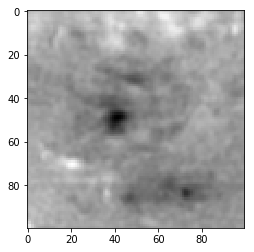

In [2]:
dataset = np.load('/home/kevinteng/Desktop/DeepLearning/Tensorflow2_0/test_npy/7-12-17-processed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

#Plot one image from the session
for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break

(100, 100, 1) float32


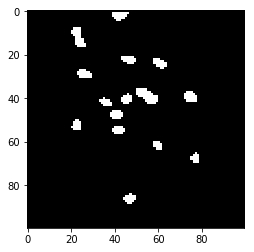

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/mat/Ori_Lin/dg-13-7-12-17ROIs.mat_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (NEW_SIZE, NEW_SIZE))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

In [4]:
#calculate mean image

mean_img_ori = utils.mean_image(re_list, IMG_SIZE)
#apply min max norm for mean image
mean_img_ori = utils.min_max_norm(mean_img_ori)
mean_img_ori = np.expand_dims(mean_img_ori, -1)
print('Max value:', np.max(mean_img_ori))
print('Min value:', np.min(mean_img_ori))


Max value: 1.0
Min value: 0.0


## Plot for Mean Images of One Session 

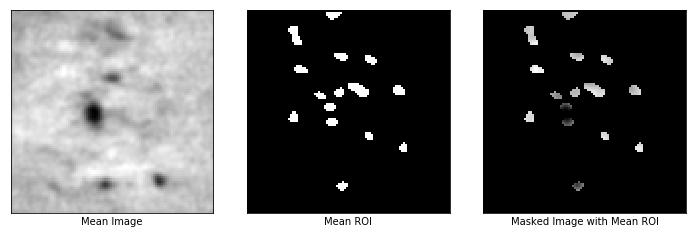

MSE:  0.590009163549358
Dice coefficient:  0.05908616320337883


In [5]:
from utils import masked_img, dice_coef_py, MSE_image
from utils_vis import plot_comparison

captions = ['Mean Image', 'Mean ROI', 'Masked Image with Mean ROI']
plot_comparison([mean_img_ori, mean_roi,masked_img(mean_img_ori, mean_roi)], 
                captions, n_col =3, figsize = (10, 10))
print('MSE: ', MSE_image(np.squeeze(mean_img_ori), mean_roi, IMG_SIZE))
#measure IOU with dice coeff
print('Dice coefficient: ',dice_coef_py(mean_roi, mean_img_ori))

----------------------------------------------------------


# Model

In [6]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block


l1_coeff = 0.99
#filters_layer = [16, 32, 64, 32, 16]
filters_layer = [32, 64]

#build network
def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True,
                                   l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                       activation='sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',
                         batch_norm = True, l1_coeff = l1_coeff)
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03
        
        

## Build Model

In [7]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv


-----------------------------------------------------------------

## Train Model

## With tf.data.Dataset.from_tensor_slices() for batch ing

In [9]:
from utils_model import img_mean, min_max_norm

#hyperparameter
BATCH_SIZE = 32
lr = 0.001
#loss function
loss_fn = tf.losses.MeanSquaredError()

#optimizer 
opt = tf.optimizers.Adam(lr)

@tf.function
def train(batched_imgs, mean_roi, img_size):
    with tf.GradientTape() as tape:
        stack_batch = tf.zeros((img_size,img_size))
        sums = 0
        
        #loop for batches 
        for img_batch in batched_imgs:
            stack = tf.zeros((img_size,img_size))
            
            #feed the network with batches 
            conv_img = model(img_batch)
            #take the mean of the batch 
            batch_mean = tf.reduce_mean(conv_img, 0)
            #stack the number of batch for each loop in number of batches
            stack_batch+= tf.squeeze(batch_mean)
            sums+=1
        
        #total mean of 
        mean_img=stack_batch/tf.cast(sums, dtype = tf.dtypes.float32)
        #ensure that the size of the images match during loss calculationta
        mean_img=tf.reshape(mean_img, [img_size, img_size, 1])
        xent = loss_fn(mean_roi, mean_img)

    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, mean_img, grads

ori_list = [] #original image list
de_list = [] #mean image fromt the network list
loss_list = [] #loss list

img_batch = re_list
epochs = 0

#This uses customed function for batching 
#batch_imgs = batch_dataset(re_list, BATCH_SIZE, IMG_SIZE)

#This uses generator for batching
batch_imgs = tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE)

while epochs < 10:
    xent, mean_img, grads =train(batch_imgs, mean_roi, IMG_SIZE)
    de_list.append(mean_img)
    loss_list.append(xent)

    print("Epochs {:2d}, Loss: {}".format(epochs, xent.numpy()))
    print("Gradient min:{}, max:{}".format(np.min(grads[0]), np.max(grads[0])))
    print()
    epochs+=1

ValueError: in converted code:

    <ipython-input-9-d914c29c2730>:37 train  *
        opt.apply_gradients(zip(grads, model.trainable_variables))
    /home/kevinteng/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:427 apply_gradients
        grads_and_vars = _filter_grads(grads_and_vars)
    /home/kevinteng/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:975 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['coord_conv_1/conv2d_1/kernel:0', 'coord_conv_1/conv2d_1/bias:0', 'batch_normalization/gamma:0', 'batch_normalization/beta:0', 'coord_conv_3/conv2d_3/kernel:0', 'coord_conv_3/conv2d_3/bias:0', 'batch_normalization_1/gamma:0', 'batch_normalization_1/beta:0', 'coord_conv_5/conv2d_5/kernel:0', 'coord_conv_5/conv2d_5/bias:0'].


## Custom function for batching

In [7]:
def batch_dataset(inp_imgs, BATCH_SIZE, IMG_SIZE):
    '''
    Custom function for creating mini-batch of dataset
    :param inp_imgs: Input image list
    :param BATCH_SIZE: batch size
    :param IMG_SIZE: input image size
    :return:
        Batched dataset of dimension (n_batch, BATCH_SIZE, IMG_SIZE, IMG_SIZE, channel)
    '''
    n_batch = int(len(inp_imgs) / BATCH_SIZE)
    mod = len(inp_imgs) % BATCH_SIZE
    if mod == 0:
        batch_imgs = np.reshape(inp_imgs, (n_batch, BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1)).astype('float32')
    else:
        # divisible part
        divisible = inp_imgs[:(len(inp_imgs) - mod)]
        divisible_re = np.reshape(divisible, (n_batch, BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1))

        # remainder part
        remainder = inp_imgs[(len(inp_imgs) - mod):]
        # remainder shape must be padded to be the same as divisible shape
        # else python will return array of type "object" which tensorflow
        # cannot convert it to tensor
        pad_dim = int(BATCH_SIZE - mod)
        pad_array = np.zeros((pad_dim, IMG_SIZE, IMG_SIZE, 1))
        remainder_pad = np.concatenate((remainder, pad_array), axis=0)
        # normalize trick for remainder to balance the mean of zeros array padding
        # such that in tf.reduce_mean, mean of remainder_pad = remainder_pad/BATCH_SIZE
        # which in this case, the true mean becomes remainder_pad/len(remainder)
        remainder_pad *= (BATCH_SIZE / len(remainder))
        remainder_pad = np.expand_dims(remainder_pad, 0)

        # stack divisible and remainder
        batch_imgs = np.concatenate((divisible_re, remainder_pad), 0).astype('float32')

    return batch_imgs

In [9]:
#toy example for batch_dataset:

toy_batch = batch_dataset(inp_imgs = re_list, BATCH_SIZE = 32, IMG_SIZE = 100)
print("Shape of input session: ", re_list.shape)
print("Shape of output function:",toy_batch.shape)

Shape of input session:  (605, 100, 100, 1)
Shape of output function: (19, 32, 100, 100, 1)


In [10]:
from utils_model import img_mean, min_max_norm

#hyperparameter
BATCH_SIZE = 16
lr = 0.001
#loss function
loss_fn = tf.losses.MeanSquaredError()

#optimizer 
opt = tf.optimizers.Adam(lr)

@tf.function
def train(batched_imgs, mean_roi, img_size):
    with tf.GradientTape() as tape:
        stack_batch = tf.zeros((img_size,img_size))
        sums = 0
        
        #loop for batches 
        for img_batch in batched_imgs:
            stack = tf.zeros((img_size,img_size))
            
            #feed the network with batches 
            conv_img = model(img_batch)
            #take the mean of the batch 
            batch_mean = tf.reduce_mean(conv_img, 0)
            #stack the number of batch for each loop in number of batches
            stack_batch+= tf.squeeze(batch_mean)
            sums+=1
        
        #total mean of 
        mean_img=stack_batch/tf.cast(sums, dtype = tf.dtypes.float32)
        #ensure that the size of the images match during loss calculationta
        mean_img=tf.reshape(mean_img, [img_size, img_size, 1])
        xent = loss_fn(mean_roi, mean_img)

    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, mean_img, grads

ori_list = [] #original image list
de_list = [] #mean image fromt the network list
loss_list = [] #loss list

img_batch = re_list
epochs = 0

#This uses customed function for batching 
batch_imgs = batch_dataset(re_list, BATCH_SIZE, IMG_SIZE)

#This uses generator for batching
#batch_imgs = tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE)

while epochs < 10:
    xent, mean_img, grads =train(batch_imgs, mean_roi, IMG_SIZE)
    de_list.append(mean_img)
    loss_list.append(xent)

    print("Epochs {:2d}, Loss: {}".format(epochs, xent.numpy()))
    print("Gradient min:{}, max:{}".format(np.min(grads[0]), np.max(grads[0])))
    print()
    epochs+=1

Epochs  0, Loss: 0.04418971389532089
Gradient min:-0.03375599533319473, max:0.030550122261047363

Epochs  1, Loss: 0.03334001451730728
Gradient min:-5.603272438747808e-05, max:7.044392987154424e-05

Epochs  2, Loss: 0.0333455391228199
Gradient min:-5.800761300633894e-06, max:1.4362997717398684e-05

Epochs  3, Loss: 0.03334861621260643
Gradient min:-5.99797795075574e-06, max:6.833448424004018e-06

Epochs  4, Loss: 0.03334946557879448
Gradient min:-6.112340997788124e-06, max:4.4458975025918335e-06

Epochs  5, Loss: 0.03334931284189224
Gradient min:-5.832983788423007e-06, max:4.726335191662656e-06

Epochs  6, Loss: 0.033348578959703445
Gradient min:-5.099837380839745e-06, max:4.911576979793608e-06

Epochs  7, Loss: 0.03334745764732361
Gradient min:-4.4742027967004105e-06, max:5.28239797858987e-06

Epochs  8, Loss: 0.03334600850939751
Gradient min:-4.38140250480501e-06, max:5.801016413897742e-06

Epochs  9, Loss: 0.03334428369998932
Gradient min:-3.607331336752395e-06, max:6.18361991655547

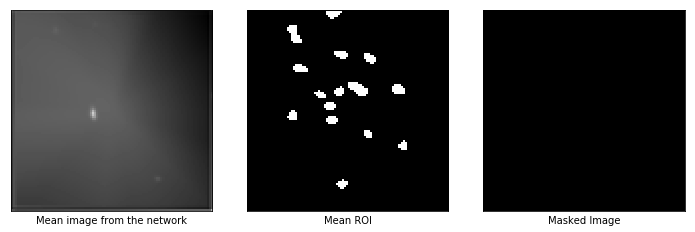

Loss: 0.033349313
Dice coefficient:  0.004357669177642384



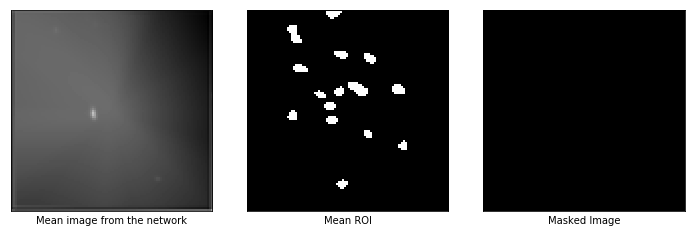

Loss: 0.03334858
Dice coefficient:  0.004378394566134832



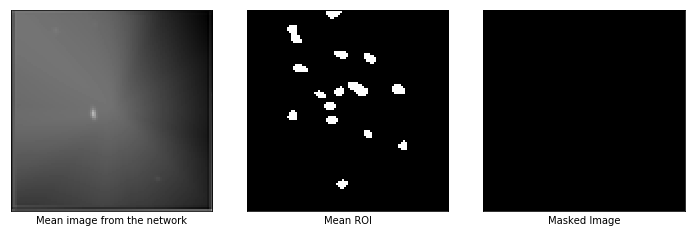

Loss: 0.033347458
Dice coefficient:  0.004409933695123859



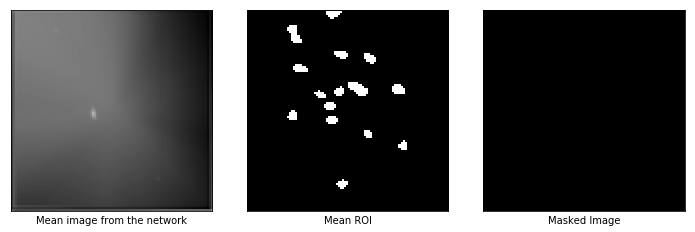

Loss: 0.03334601
Dice coefficient:  0.00445069858201038



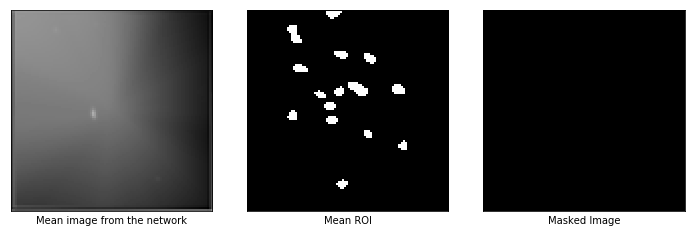

Loss: 0.033344284
Dice coefficient:  0.004499226602814446


In [11]:
#plot for mean image of last 10 steps w.r.t mean roi 
last_n_steps = 5
for i in range(last_n_steps):
    mean_image = de_list[len(de_list) - last_n_steps + i]
    mean_image = np.asarray(mean_image) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    
    #plot
    inp_imgs = [mean_image , mean_roi, masked_image]
    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - last_n_steps + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))

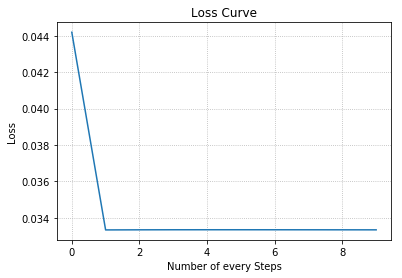

In [12]:
utils_vis.plot_loss(loss_list)

--------------------------------

# Appendix

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
coord_conv_1 (CoordConv)     (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
coord_conv_3 (CoordConv)     (None, 100, 100, 64)      19648     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0     